In [14]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import img_as_ubyte

In [16]:
def preprocess_drive_image(image_path, roi_mask_path=None, size=(512, 512)):
    #Applies ROI masking,CLAHE enhancement and resizing to a SINGLE image
    # Load image (PIL to NumPy)
    img = Image.open(image_path).convert('RGB')
    img = np.array(img)

    # Convert to grayscale 
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply ROI mask if provided
    if roi_mask_path and os.path.exists(roi_mask_path):
        roi_mask = Image.open(roi_mask_path)
        roi_mask = roi_mask.resize(img.shape[::-1], Image.NEAREST)
        roi_mask = np.array(roi_mask)
        img = cv2.bitwise_and(img, img, mask=roi_mask)

    # Resize to uniform size (e.g., 512x512)
    img = cv2.resize(img, size)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    return img


In [18]:

def preprocess_drive_mask(mask_path, size=(512, 512)):
   #preprocess the ground truth mask (manually segmented mask)
    mask = Image.open(mask_path).convert('L')
    mask = np.array(mask)

    # Resize and binarize the mask
    mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.uint8) * 255  # Convert to binary (0 or 255)

    return mask

In [27]:
def preprocess_drive_dataset(images_dir, masks_dir=None, roi_masks_dir=None, size=(512, 512)):
   
    #Preprocess all DRIVE images in a folder.
    valid_exts = ('.tif', '.jpg', '.png', '.jpeg', '.bmp')  # valid image types
    image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(valid_exts)])
    
    preprocessed_images = []
    preprocessed_masks = []

    for img_file in image_files:
        # Construct full paths
        image_path = os.path.join(images_dir, img_file)

        roi_path = None
        if roi_masks_dir:
            roi_name = img_file.replace('.tif', '_mask.gif')  # follows DRIVE naming
            roi_path = os.path.join(roi_masks_dir, roi_name)

        # Preprocess image
        image = preprocess_drive_image(image_path, roi_mask_path=roi_path, size=size)
        preprocessed_images.append(image)

        # Preprocess mask 
        if masks_dir:
            base = img_file.replace('_training.tif', '').replace('.tif', '')
            mask_file = f"{base}_manual1.gif"
            mask_path = os.path.join(masks_dir, mask_file)

            if os.path.exists(mask_path):
                mask = preprocess_drive_mask(mask_path, size=size)
                preprocessed_masks.append(mask)

    if masks_dir:
        return preprocessed_images, preprocessed_masks
    else:
        return preprocessed_images

In [28]:
#Apply preprocessing to train dataset
train_images_dir = "DRIVE/training/images"
train_masks_dir = "DRIVE/training/1st_manual"
train_roi_dir = "DRIVE/training/mask"

train_imgs, train_masks = preprocess_drive_dataset(
    images_dir=train_images_dir,
    
    masks_dir=train_masks_dir,
    roi_masks_dir=train_roi_dir,
    size=(512, 512)
)

In [29]:
#Apply preprocessing to test dataset
test_images_dir = "DRIVE/test/images"
test_roi_dir = "DRIVE/test/mask"

test_imgs = preprocess_drive_dataset(
    images_dir=test_images_dir,
    roi_masks_dir=test_roi_dir,
    size=(512, 512)
)


In [34]:
def display_drive_samples(original_dir, preprocessed_imgs, preprocessed_masks=None, count=5):
    #Displays original, preprocessed image and mask 
    
     image_files = sorted([
        f for f in os.listdir(original_dir)
        if f.lower().endswith(('.tif', '.png', '.jpg'))
     ])

     for i in range(count):
        if i >= len(preprocessed_imgs):
            break

        original_path = os.path.join(original_dir, image_files[i])
        original = Image.open(original_path).convert('RGB')
        original_np = np.array(original)

        pre_img = preprocessed_imgs[i]
        
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Sample: {image_files[i]}", fontsize=14)

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(original_np)
        plt.title("Original")
        plt.axis('off')

        # Preprocessed Image (grayscale)
        plt.subplot(1, 3, 2)
        plt.imshow(pre_img, cmap='gray')
        plt.title("Preprocessed")
        plt.axis('off')

        # Mask if available
        if preprocessed_masks is not None and i < len(preprocessed_masks):
            plt.subplot(1, 3, 3)
            plt.imshow(preprocessed_masks[i], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

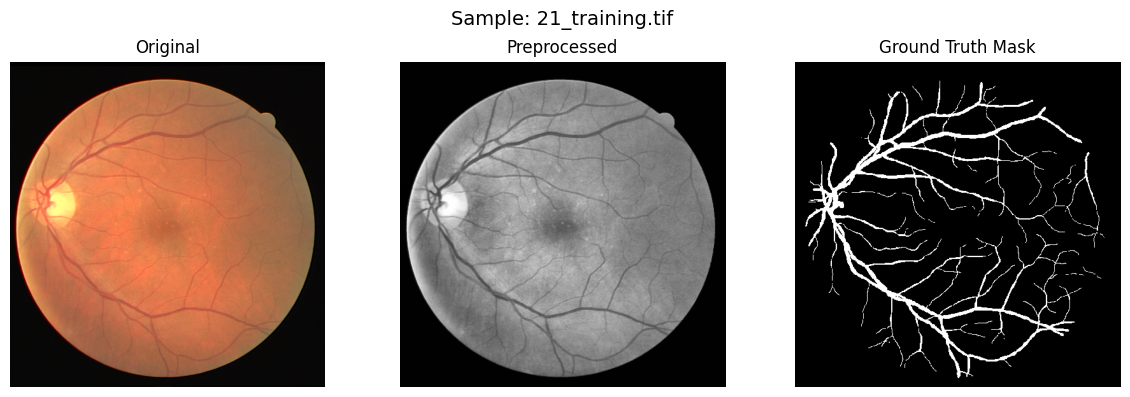

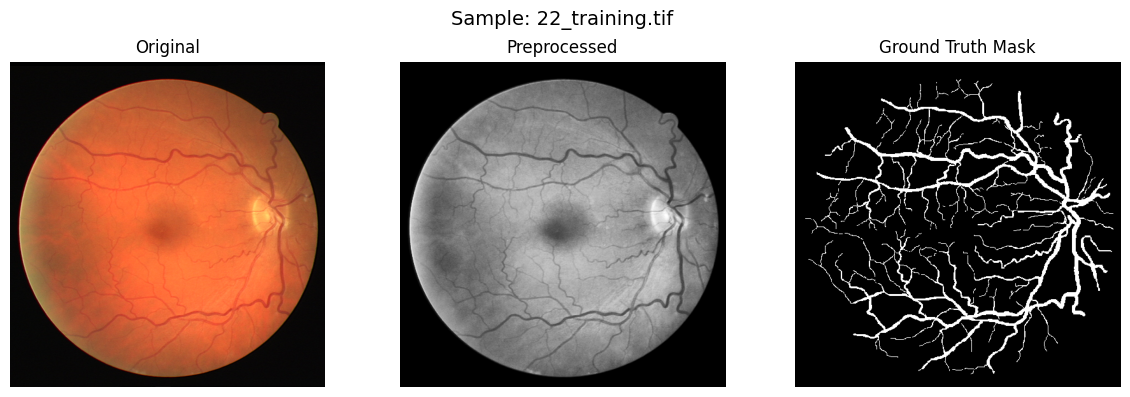

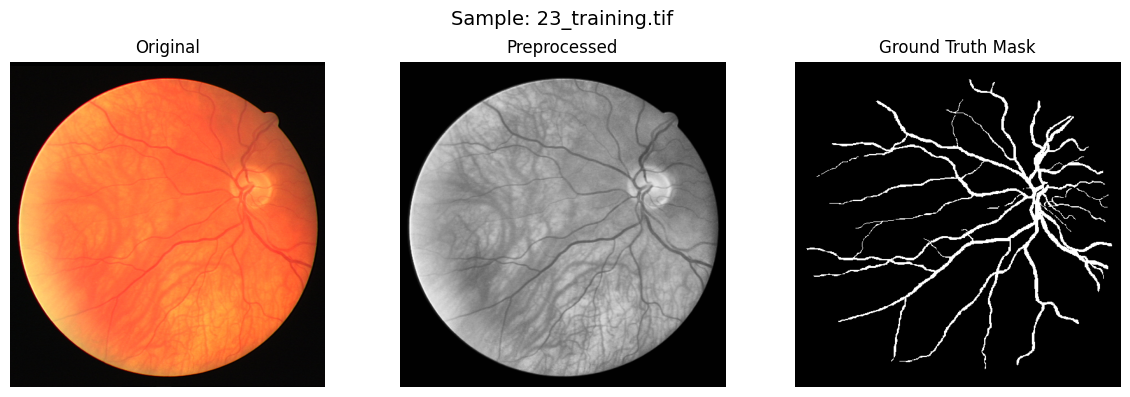

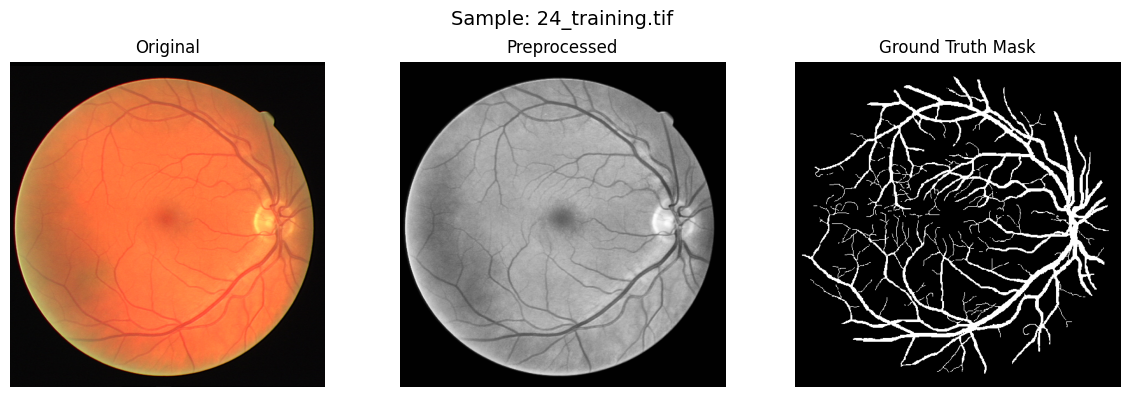

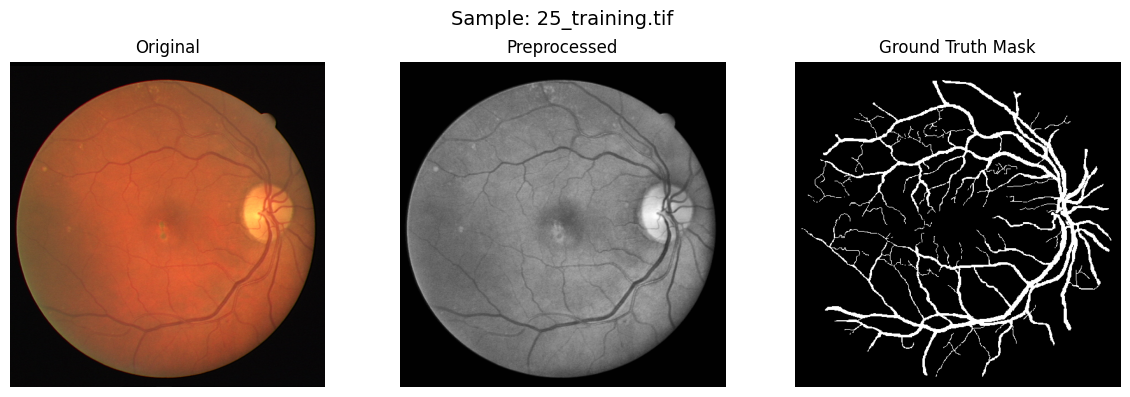

In [36]:
display_drive_samples(
    original_dir="DRIVE/training/images",
    preprocessed_imgs=train_imgs,
    preprocessed_masks=train_masks,
    count=5  # Change this if you want to display more/less
)


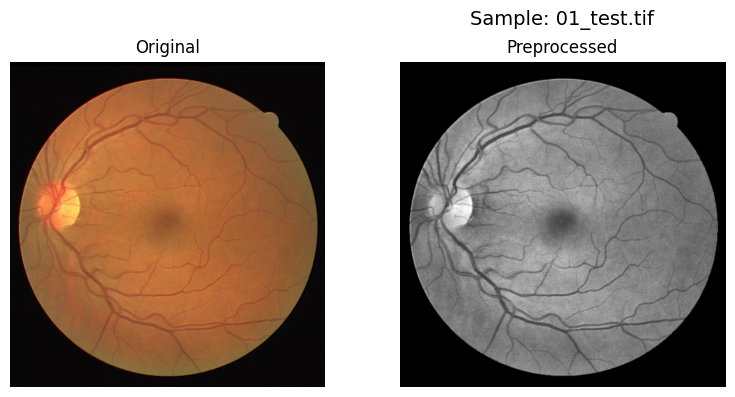

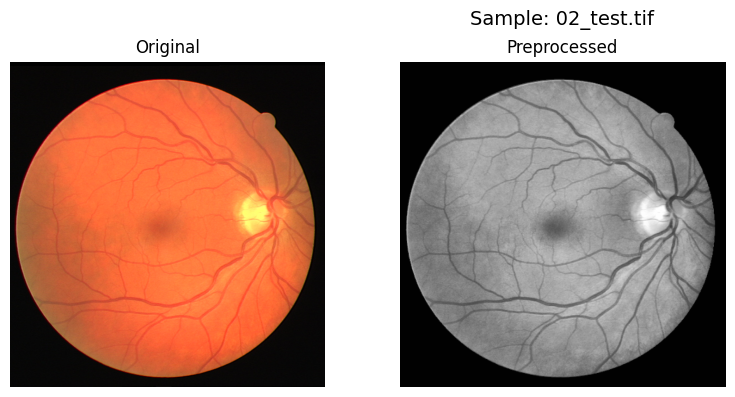

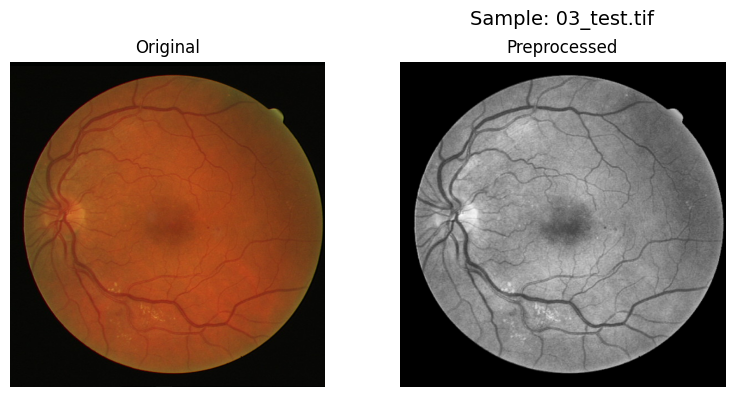

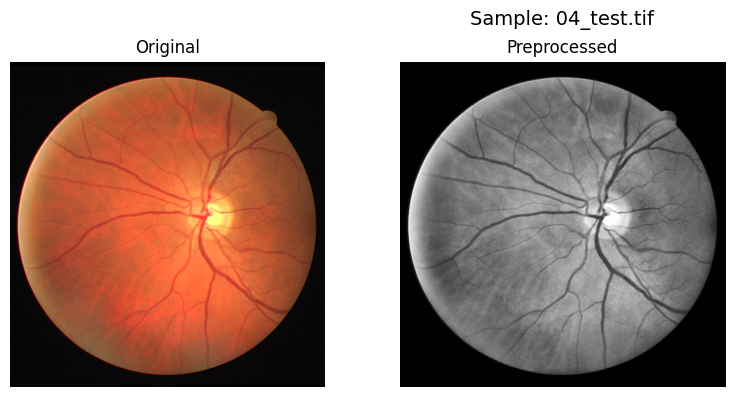

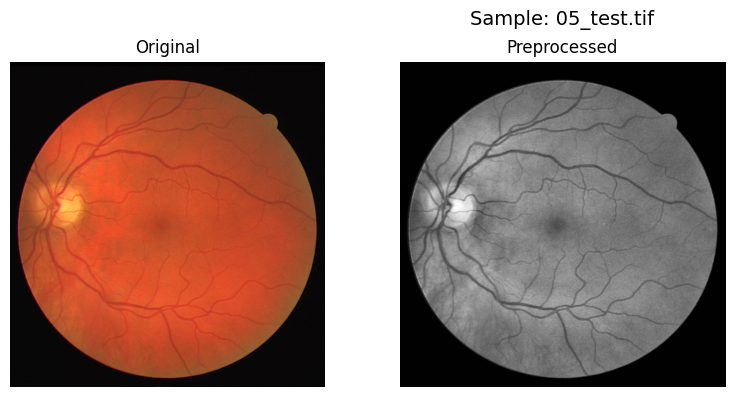

In [35]:
display_drive_samples(
    original_dir="DRIVE/test/images",
    preprocessed_imgs=test_imgs,
    count=5  # Change this if you want to display more/less
)
